In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
import cv2
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import scipy.io as sio
from scipy.signal import convolve2d, convolve
from skimage.morphology import skeletonize, remove_small_objects
from skimage.measure import label, regionprops_table
from skimage.color import label2rgb

In [132]:
# Use MSE loss for training
class TracerNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, ceil_mode=True)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=0),
        )
        
        self.fc = nn.Linear(1024, 1)
    
    def load_mat_state(self, file):
        params = sio.loadmat(file)['state'][0][0][0][0]
        params = [torch.tensor(x.transpose(x.ndim - 1 - np.arange(x.ndim))).squeeze() for x in params]

        def load_linear(layer, start_idx):
            layer.weight = nn.Parameter(params[start_idx])
            layer.bias = nn.Parameter(params[start_idx+1])

        def load_conv_block(block, start_idx):
            load_linear(block[0], start_idx)
            if len(block) > 2: load_linear(block[1], start_idx+2)

        # can stay hardcoded for now
        load_conv_block(self.conv1, 0)
        load_conv_block(self.conv2, 5)
        load_conv_block(self.conv3, 10)
        load_conv_block(self.conv4, 15)
        load_conv_block(self.conv5, 20)
        load_linear(self.fc, 22)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.fc(x.flatten(1))
        return x

In [285]:
# ported from https://github.com/tsogkas/matlab-utils/blob/master/nms.m
def contour_orient(E, r):
    if r <= 1:
        p = 12 / r / (r + 2) - 2
        f = np.array([1, p, 1]) / (2 + p)
        r = 1
    else:
        f = np.concatenate([np.arange(1, r+1), [r+1], np.arange(r, 0, -1)]) / (r + 1)**2
    E2 = np.pad(E, [r, r], mode='symmetric')
    E2 = convolve(convolve(E2, f[np.newaxis], mode='valid'), f[:, np.newaxis], mode='valid')
    grad_f = np.array([-1, 2, -1])
    Dx = convolve2d(E2, grad_f[np.newaxis], mode='same')
    Dy = convolve2d(E2, grad_f[:, np.newaxis], mode='same')
    f = np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1]])
    F = convolve2d(E2, f, mode='same') > 0
    Dy[F] = -Dy[F]
    return np.mod(np.arctan2(Dy, Dx), np.pi)

def nms(E, r=3, s=1):
    O = contour_orient(E, r)
    
    Dx = np.cos(O)
    Dy = np.sin(O)
    
    ht, wd = E.shape
    E1 = np.pad(E, r+1, mode='edge')
    
    cs, rs = np.meshgrid(np.arange(wd), np.arange(ht))

    for i in range(-r, r+1):
        if i == 0: continue
        cs0 = i * Dx + cs
        dcs = cs0 - np.floor(cs0)
        cs0 = np.floor(cs0).astype(int)
        
        rs0 = i * Dy + rs
        drs = rs0 - np.floor(rs0)
        rs0 = np.floor(rs0).astype(int)
        
        rs0_p = rs0 + r + 1
        cs0_p = cs0 + r + 1

        rs0_p = np.clip(rs0_p, 0, ht + 2*r)
        cs0_p = np.clip(cs0_p, 0, wd + 2*r)
        
        E2 = (1 - dcs) * (1 - drs) * E1[rs0_p + 0, cs0_p + 0]
        E2 += dcs * (1 - drs) * E1[rs0_p + 0, cs0_p + 1]
        E2 += (1 - dcs) * drs * E1[rs0_p + 1, cs0_p + 0]
        E2 += dcs * drs * E1[rs0_p + 1, cs0_p + 1]

        E[E * 1.01 < E2] = 0

    # Suppress borders
    for i in range(s):
        scale = (i) / s
        E[i, :] *= scale
        E[-i-1, :] *= scale
        E[:, i] *= scale
        E[:, -i-1] *= scale

    return E 

In [ ]:
def chboards(height, width, bss):
    num_blocks_x = height // bss
    num_blocks_y = width // bss
    checker_pattern = (-1) ** (np.add.outer(np.arange(num_blocks_x), np.arange(num_blocks_y)))
    A = np.kron(checker_pattern, np.ones((bss, bss)))
    return A[:height, :width]

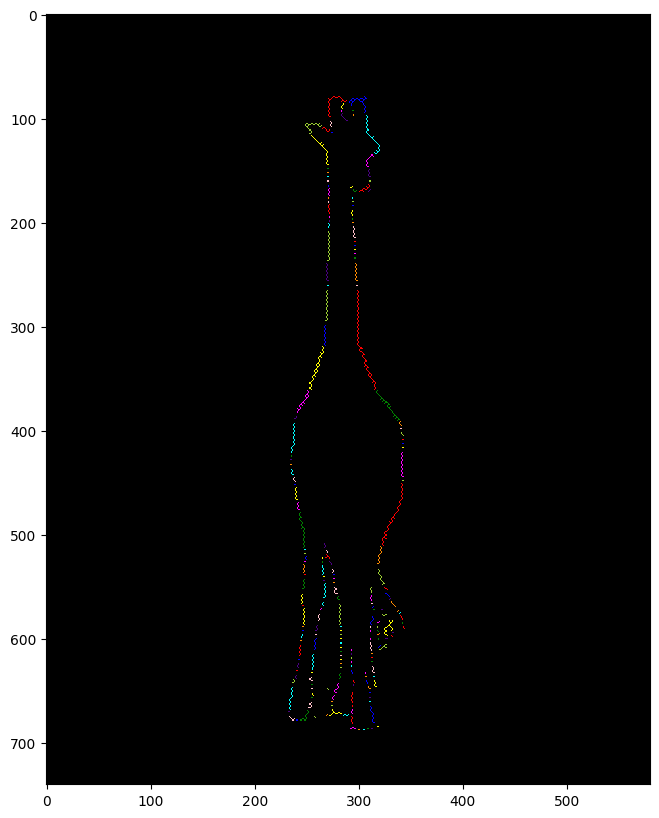

In [ ]:
p_step = 3
w_size = 2 * p_step + 1

# Create grid of coordinates relative to center
y, x = np.mgrid[-p_step:p_step+1, -p_step:p_step+1]

# Create mask with border set to 0
center_mask = np.ones((w_size, w_size), dtype=bool)
center_mask[0, :] = False
center_mask[-1, :] = False
center_mask[:, 0] = False
center_mask[:, -1] = False

# Compute angles, shift by pi, convert to degrees
vectormatrix = x + 1j * y
angle_deg = np.degrees(np.angle(vectormatrix) + np.pi)
angle_deg = np.round(angle_deg)

# Function to zero out specified angles in the inner region
def zero_angles(angles, center_mask, target_angles):
    for t in target_angles:
        angles[(angles == t) & center_mask] = 0
    return angles

# Target angles to zero
targets = [0, 45, 90, 135, 180, 225, 270, 315, 360]

# Remove angles where inner mask is True
angle_deg = zero_angles(angle_deg, center_mask, targets)
angle_deg_mirr = np.flipud(angle_deg) * -1

# Get unique angles
unique_angles = np.unique(angle_deg).astype(np.int32)
unique_angles_mirr = np.unique(angle_deg_mirr).astype(np.int32)

imgs = [cv2.imread(file)[...,::-1] for file in glob("Input/RGB/*")]
contours = [cv2.imread(file, -1) for file in glob("Input/SCM/*")]

# load model
tracer_net = TracerNet()
tracer_net.load_mat_state("Models/net-epoch-559.mat")
tracer_net.to("cuda")

for img, cont in zip(imgs, contours):
    img = np.flip(img, axis=1).astype(np.float32) * 256
    cont = np.flip(cont, axis=1).astype(np.float32)

    pad_width = [(50, 50), (50, 50)]
    img = np.pad(img, pad_width + [(0, 0)], mode='constant', constant_values=0)
    cont = np.pad(cont, pad_width, mode='constant', constant_values=0)

    thresh = np.max(cont) * 0.5
    non_max_supp = nms(cont, 3, 2)
    non_max_supp[non_max_supp < thresh] = 0
    
    A = chboards(*cont.shape, bss=2)
    non_max_supp[A > 0] = 0
    non_max_supp[non_max_supp > 0] = 1

    BW3 = skeletonize(non_max_supp.astype(bool))
    BW3 = remove_small_objects(BW3, min_size=2, connectivity=8)
    labeled_image = label(BW3)
    colored_labels = label2rgb(labeled_image, bg_label=0, kind='overlay')


    plt.figure(figsize = (10,10))
    plt.imshow(colored_labels, cmap='gray', interpolation='nearest')